<a href="https://colab.research.google.com/github/cu-applied-math/appm-4600-numerics/blob/main/Demos/Ch9_EigenvaluesTheBadWay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I know how to find eigenvalues! My linear algebra textbook told me

**Step 1** You form the characteristic polynomial
$$p_A(\lambda)=\text{det}( A - \lambda I)$$
and then find its roots to get the eigenvalues $\lambda_1,\ldots,\lambda_n$.

**Step 2** Finding *eigenvectors* for a given $\lambda_k$ just means solving the linear system $(A-\lambda_k) \vec{x} = \vec{0}$.

This lab only looks at *step 1*, finding eigenvalues, since if that fails, then step 2 would fail too.

#### Learning objectives
- Explore the above proposed method and see if it works
- Understand why we need to develop specialized methods to solve eigenvalue problems


*Copyright 2025 Department of Applied Mathematics, University of Colorado Boulder. Released under a BSD 3-Clause license*



In [1]:
import numpy as np
import scipy.linalg as sla
import scipy.optimize as opt
import time
from matplotlib import pyplot as plt
from numpy.polynomial import Polynomial

## How to find the characteristic polynomial?
Cofactor expansion is slow, $O(n!)$, and complicated since $\lambda$ is indeterminant.

Matlab's [`poly(A)`](https://www.mathworks.com/help/matlab/ref/poly.html) does it, but it "cheats": it finds the eigenvalues in order to construct $p_A(\lambda)$!! We want the opposite.

The standard approach is the [Faddeev–LeVerrier algorithm](https://en.wikipedia.org/wiki/Faddeev%E2%80%93LeVerrier_algorithm) which requires computing $A^k$ for $k=1,2,\ldots,n$, so this is an $O(n^4)$ algorithm.  I'm not sure about its stability, but my guess is that it's not good.

In [ ]:
# Borrow implementation from Ryan J. Kinnear
# https://github.com/RJTK/faddeev_leverrier/blob/master/faddeev_leverrier.py
# "On Faddeev-Leverrier's method for the computation of the characteristic polynomial of a matrix and of eigenvectors,"
# Helmberg et al., Linear Algebra and its Applications, 1993. http://dx.doi.org/10.1016/0024-3795(93)90214-9
def faddeev_leverrier(A):
    ''' P(x) ^= det(xI - A) = a_0 * x^n + a_1 * x^(n - 1) + ... + a_n
    We return the list a = [a_0, a_1, ..., a_n] '''
    n = A.shape[0]

    a = np.array([1.])
    Ak = np.array(A)
    for k in range(1, n + 1):  # run this loop n times
        ak =  -Ak.trace() / k
        a  =  np.append(a, ak)
        Ak += np.diag(np.repeat(ak, n))
        Ak =  np.dot(A, Ak) # matrix-matrix multiply, O(n^3) cost
    return a

Let's see if it works:

In [ ]:
n   = 10
rng = np.random.default_rng(1234)
A   = rng.standard_normal((n,n))
eigs = sla.eigvals(A)
print(eigs) # our "true" solution

[-4.2180712 +0.j          2.37652278+2.56102103j  2.37652278-2.56102103j
 -1.29890599+2.15827931j -1.29890599-2.15827931j  0.28723549+1.27233139j
  0.28723549-1.27233139j  1.1502551 +0.j         -1.62036783+0.j
 -1.77786089+0.j        ]


and try the Faddeev-LeVerrier:

In [ ]:
coeff = faddeev_leverrier(A)[::-1] # order these degree 0 to degree n
poly = Polynomial(coeff)
print( poly.roots() )

[-4.2180712 +0.j         -1.77786089+0.j         -1.62036783+0.j
 -1.29890599-2.15827931j -1.29890599+2.15827931j  0.28723549-1.27233139j
  0.28723549+1.27233139j  1.1502551 +0.j          2.37652278-2.56102103j
  2.37652278+2.56102103j]


In [ ]:
# Not too bad.  Note that this collection of eigenvalues isn't in any particular order
# so if we want to compare them, we should make sure we're comparing the same eigenvalues
def compare_eigenvalues( lambda1, lambda2 ):
    l1 = np.sort_complex(lambda1)
    l2 = np.sort_complex(lambda2)
    print(f'||lambda1 - lambda2|| is {np.linalg.norm(l1-l2):.2e}')

compare_eigenvalues( eigs, poly.roots() )

||lambda1 - lambda2|| is 4.05e-14


In [ ]:
# Let's try a larger problem
n   = 50
A   = rng.standard_normal((n,n))
eigs = sla.eigvals(A)
coeff = faddeev_leverrier(A)[::-1] # order these degree 0 to degree n
poly = Polynomial(coeff)
compare_eigenvalues( eigs, poly.roots() )

||lambda1 - lambda2|| is 1.05e-06


In [ ]:
# Even larger problem
n   = 100
A   = rng.standard_normal((n,n))
eigs = sla.eigvals(A)
coeff = faddeev_leverrier(A)[::-1] # order these degree 0 to degree n
poly = Polynomial(coeff)
compare_eigenvalues( eigs, poly.roots() )

||lambda1 - lambda2|| is 6.66e+01


That's not a good sign. What about the complexity?

In [ ]:
nList = np.logspace(2,2.7,num=6,dtype=int)
timeList = []
for n in nList:
    A = rng.standard_normal((n,n))
    tic = time.time()
    coeff = faddeev_leverrier(A)
    toc = time.time()
    timeList.append(toc-tic)

/tmp/ipython-input-1512365532.py:13: RuntimeWarning: overflow encountered in reduce
  ak =  -Ak.trace() / k
/tmp/ipython-input-1512365532.py:13: RuntimeWarning: invalid value encountered in reduce
  ak =  -Ak.trace() / k


ooh, that overflow error doesn't sound good. Let's plot the time:

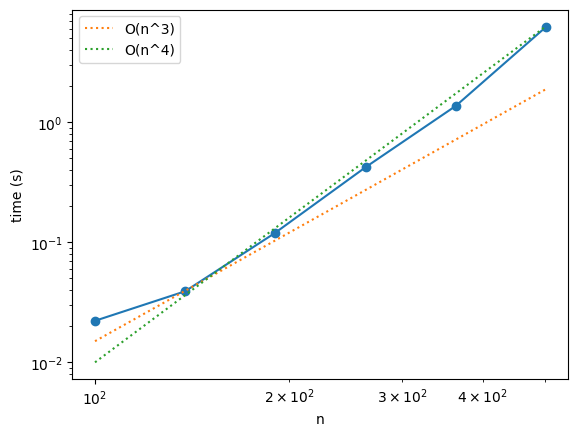

In [ ]:
plt.loglog( nList, timeList, 'o-')
plt.loglog( nList, 1.5e-8*nList**3, ':',label='O(n^3)')
plt.loglog( nList, 1e-10*nList**4, ':',label='O(n^4)')
plt.ylabel('time (s)')
plt.xlabel('n')
plt.legend()
plt.show()

Not great. It really is $O(n^4)$. Our goal will be to find something better than this.

## What about LU factorizations?

The idea is that we treat $p(\lambda) = |A-\lambda I|$ as just a univariate function and do root finding

So the first question is, how to compute determinants?
- Short answer: `scipy.linalg.det`
- Long answer: see below

In [ ]:
n   = 10
rng = np.random.default_rng(1234)
A   = rng.standard_normal((n,n))
eigs = sla.eigvals(A)
print( sla.det(A), np.real_if_close(eigs.prod(),1000) ) # two ways to do it

-1841.875310904856 -1841.8753109048678


But let's do it ourselves: we use that if
$$A=P^\top L U$$
is the pivoted LU factorization, then
$$|A| = |P| \times |L| \times |U|$$
and $|P|$ is cheap since it's a permutation matrix, $|L|=1$ since it has ones on the diagonal, and $|U|=\prod_{i=1}^m U_{ii}$ is also cheap. The dominant cost is $O(n^3)$ for the LU factorization

In [ ]:
def our_det(A):
    n = A.shape[0]
    LU, piv = sla.lu_factor(A)
    nswaps = (piv != np.arange(n)).sum()
    signP  = (-1)**nswaps
    return signP*np.diag(U).prod()

print(our_det(A))

-1841.8753109048566


Be careful! You *must* use the `lu_factor` version because it returns the "pivots" in the right kind of format (that is, in the swap format). If we know the number of swaps, that flips the sign of the determinant every time we swap.

If you do:
```Python
P,L,U = sla.lu(A)
```
or
```Python
p,L,U = sla.lu(A,p_indices=True)
```
then the permutation matrix `P` or vector `p` is not in the "swap" format, so it's not so simple to determine the sign of its determinant.  Code on the internet, like https://kitchingroup.cheme.cmu.edu/blog/2013/04/01/Computing-determinants-from-matrix-decompositions, gets this wrong.  By chance, sometimes it's the right sign, so it is easy for them to miss this bug.

### So now do root finding
We can't find all $n$ eigenvalues at once. We'd get them one-by-one.

Also, we may have complex eigenvalues, which is even more of a headache. Let's not worry about that for now

In [ ]:
n   = 10
rng = np.random.default_rng(1234)
A   = rng.standard_normal((n,n))
A   = (A+A.T)/2 # make it symmetric so eigenvalues are real
eigs = sla.eigvalsh(A) # the "h" stands for Hermitian. Real and symmetric is Hermitian too.
# eigs = sla.eigvals(A) # this will have small imaginary part
print(eigs)


def f(mu):
    """ mu is the proposed eigenvalue.
    Note that we don't use "lambda" since that's a special keyword in python! """
    n = A.shape[0]
    return sla.det(A-mu*np.eye(n))

[-4.58805159 -3.0375005  -2.40848198 -1.95738376 -1.20537594 -0.62549073
  1.33882413  2.07878074  2.82750862  3.84083075]


In [ ]:
sol = opt.root_scalar(f, x0=-4)
l   = sol.root
print(l)

-3.0375004985362066


In [ ]:
nearest_l = eigs[ (np.abs(eigs - l)).argmin() ]
print(l,nearest_l)
print(f'Error is {abs(l-nearest_l):.2e}')

-3.0375004985362066 -3.037500498536207
Error is 4.44e-16


Let's see how robust this is.  We can do a very "easy" example: let $A=I$! What could be simpler? All the eigenvalues are 1

In [ ]:
n   = 10
A   = np.eye(n)
eigs = sla.eigvalsh(A)

def f(mu):
    """ mu is the proposed eigenvalue.
    Note that we don't use "lambda" since that's a special keyword in python! """
    n = A.shape[0]
    return sla.det(A-mu*np.eye(n))

sol = opt.root_scalar(f, x0=0)
l   = sol.root
nearest_l = eigs[ (np.abs(eigs - l)).argmin() ]
print(l,nearest_l)
print(f'Error is {abs(l-nearest_l):.2e}')

0.9948462915048476 1.0
Error is 5.15e-03


In [ ]:
sol

      converged: False
           flag: convergence error
 function_calls: 100
     iterations: 50
           root: 0.9948462915048476
         method: newton

What happened?  Well, we have a multiple root at $\lambda=1$... in fact, it has multiplicity $n$! And this makes Newton's method converge **very slowly**

## Summary
None of these ideas were very satisfactory. That is why we're going to spend time finding something better

## What about eigenvectors?
Suppose we have eigenvalues. Can we do the textbook method to find eigenvectors?

In [2]:
n   = 10
rng = np.random.default_rng(1234)
A   = rng.standard_normal((n,n))
A   = (A+A.T)/2 # make it symmetric so eigenvalues are real, to simplify things for now
eigs = sla.eigvalsh(A) # the "h" stands for Hermitian. Real and symmetric is Hermitian too.
print(eigs)

[-4.58805159 -3.0375005  -2.40848198 -1.95738376 -1.20537594 -0.62549073
  1.33882413  2.07878074  2.82750862  3.84083075]


In [4]:
# Find an eigenvector the textbook way
lam = eigs[0] # pick an eigenvalue

B = A - lam*np.eye(n)

v = sla.solve(B,np.zeros(n))

print(v)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=4.53457e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


That also failed! The matrix $B=A-\lambda I$ is supposed to be singular, but it's not perfectly singular (it's very close... the condition number is $10^{17}$).  So then the only solution to $B\vec{v}=\vec{0}$ is $\vec{v}=0$, which is not an eigenvector.

So again, we need to find a more robust method...